# Imports

In [2]:
import random
import imutils

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import tensorflow as tf
import keras
print(tf.config.list_physical_devices('GPU'))

import cv2
import keras_nlp


/tmp/ipykernel_6940/3196427401.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-01 12:56:16.015559: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-01 12:56:16.015599: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-01 12:56:16.016451: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable t

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
tf.__version__, keras.__version__

('2.15.0', '3.0.0')

# Data load

(32, 32)


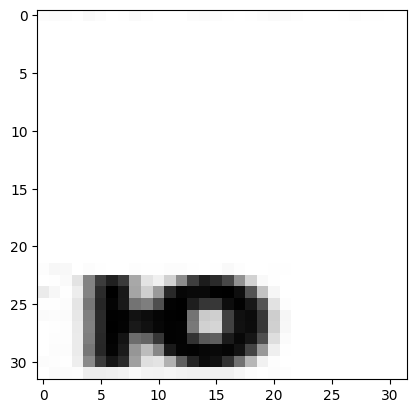

In [4]:
let = cv2.imread('data/letterlist.jpg', 0)
let = let[15:780,:]
num_letters = 33
num_fonts = 21
num_classes = 33
input_shape = (32,32,1)

def get_letter(font_num, letter_num):
    letter = let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]
    return cv2.resize(letter, input_shape[:-1])

def get_letter_variants(letter_num):
        return let[:,
           let.shape[1]//num_letters*(letter_num-1):let.shape[1]//num_letters*letter_num,
           ]

def get_font_variants(font_num):
    return let[let.shape[0]//num_fonts*(font_num-1):let.shape[0]//num_fonts*font_num,
           :,
           ]
test = get_letter(21,33)
print(test.shape)
plt.imshow(test, cmap='gray')

# Augmenters

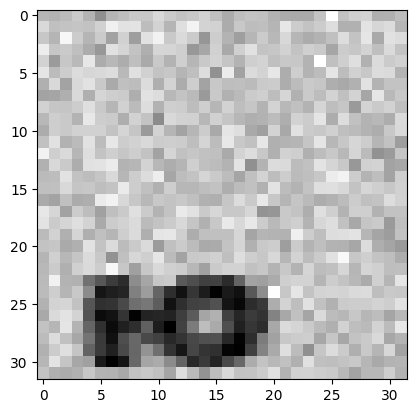

In [5]:
class BaseAugmenter():
    def __init__(self, chanse=0.5):
        self.chance = chanse
        
    def __call__(self, img, *args, **kwargs):
        augmented = False
        if random.random()<= self.chance:
            try:
                img = self._apply(img, *args, **kwargs)
                augmented = True
            except Exception as e:
                print(e)
            
        return img, augmented
    
    def _apply(self, img, *args, **kwargs):
        return img
    
class NoiseAugmenter(BaseAugmenter):
    def _apply(self, letter, max=30):
        noise = np.random.normal(size=(letter.shape))*max
        return letter+noise
    
plt.imshow(NoiseAugmenter(1)(test)[0], cmap='gray')

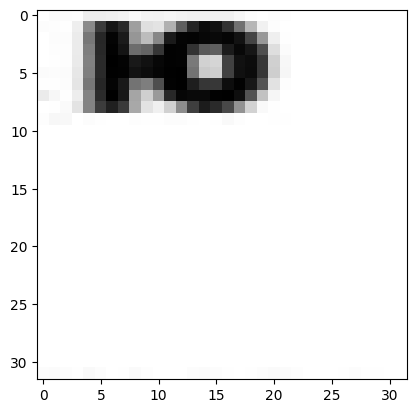

In [6]:
class FlipAugmenter(BaseAugmenter):

    def _apply(self, letter, mode='horizontal'):
        if mode == 'horizontal':
            return np.flip(letter, axis=0)
        elif mode == 'vertical':
            return np.flip(letter, axis=1)
        elif mode == 'random':
            axis = random.random() < 0.5
            return np.flip(letter, axis=int(axis))
        
plt.imshow(FlipAugmenter(1)(test)[0], cmap='gray')  

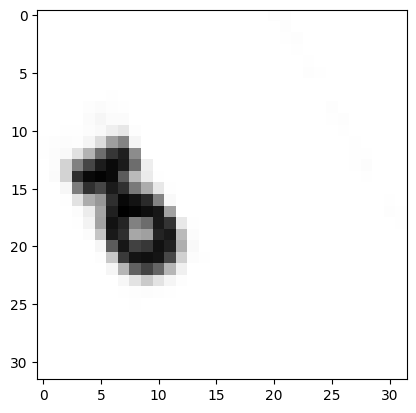

In [7]:
class RotationAugmenter(BaseAugmenter):
    
    def _apply(self, letter, angle=60):
        image = np.zeros_like(letter) + 255 - letter
        rotated = imutils.rotate_bound(image, angle)
        rotated = np.zeros_like(rotated) + 255 - rotated
        rotated = cv2.resize(rotated, (letter.shape[1], letter.shape[0]))
        return rotated
rotated = RotationAugmenter(1)(test)[0]
plt.imshow(rotated, cmap='gray')

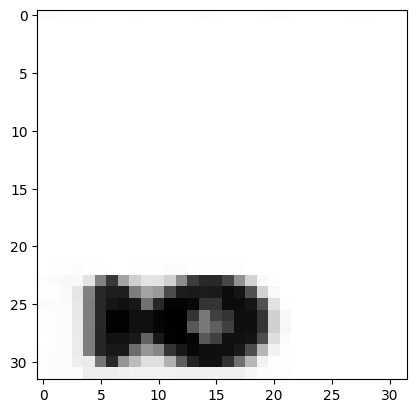

In [8]:
class BlurAugmenter(BaseAugmenter):
    
    def _apply(self, letter, kernel_size=3):
        return cv2.medianBlur(letter, kernel_size)
    
plt.imshow(BlurAugmenter(1)(test)[0], cmap='gray')

In [9]:
class MultipleAugmenter():
    NOISE_CHANCE = 0.1
    NOISE_HARDNESS = 20
    
    FLIP_CHANCE = 0.3
    
    ROTATE_CHANCE = 0.15
    
    BLUR_CHANCE = 0.1
    BLUR_HARD_CHANCE = 0.05
    
    images = []
    captions = []
    
    def __init__(self, images, captions):
        self.images_orig = images
        self.captions_orig = captions
        self.augmenters = [
            FlipAugmenter(self.FLIP_CHANCE),
            RotationAugmenter(self.ROTATE_CHANCE),
            BlurAugmenter(self.BLUR_CHANCE),
            BlurAugmenter(self.BLUR_HARD_CHANCE),
            
        ]
        self.noise = (NoiseAugmenter(self.NOISE_CHANCE), self.NOISE_HARDNESS)
        
        self.augment_args = [
            ['random'],
            [],
            [3],
            [5],

        ]    
    
    def random_augment(self, rounds = 1, seed = 42, save_last=False):
        random.seed(seed)
        
        images = self.images_orig
        captions = self.captions_orig
        
        for _ in range(rounds):
            print(len(images))
            num_images = len(images)
            for n in range(num_images):
                image = images[n]
                caption = captions[n]
                
                for n, aug in enumerate(self.augmenters):
                    aug_args = self.augment_args[n]
                    if not aug_args:
                        aug_args = [random.randint(-15,15)]
                    image, augmented = aug(image, *aug_args)
                    if augmented:
                        images.append(image)
                        captions.append(caption)
                    
            if save_last:
                images = images[num_images:]
                captions = captions[num_images:]
        

                
        self.images = images
        self.captions = captions        
        self._apply_noise()
        self._normalize()
        
    def _apply_noise(self):
        for n, im in enumerate(self.images):
            noise_augmenter, hardeness = self.noise
            image, augmented = noise_augmenter(im, hardeness)
            if augmented:
                self.images[n] = image        
        
    def _normalize(self):
        for n, im in enumerate(self.images):
            im = np.array(im)
            self.images[n] = im/im.max()

# Data preparation

In [10]:
images = []
captions = []
captions_base = "Ё Й Ц У К Е Н Г Ш Щ З Х Ъ Ф Ы В А П Р О Л Д Ж Э Я Ч С М И Т Ь Б Ю".split(' ')
for i in range(1, num_fonts+1):
    for j in range(1, num_letters+1):
        images.append(get_letter(i,j))
        captions.append(captions_base[j-1])

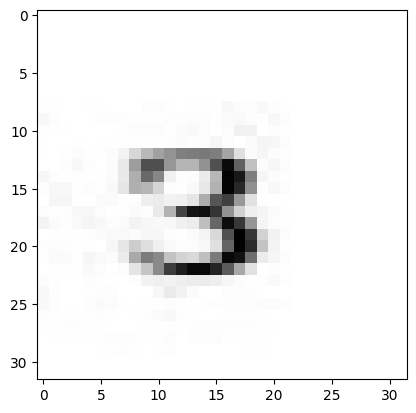

In [11]:
plt.imshow(images[10], cmap='gray')

In [12]:
len(images)

693

In [13]:
aug = MultipleAugmenter(images.copy(), captions.copy())

In [14]:
aug.random_augment(10)

693
1117
1763
2814
4490
7161
11452
18331
29290
46852


Э


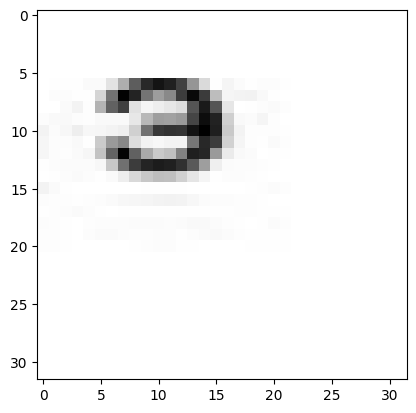

In [15]:
n = 1000
print(aug.captions[n])
plt.imshow(aug.images[n], cmap='gray')

In [16]:
np.array(aug.images).shape

(74975, 32, 32)

## Train data

In [17]:
x_data = np.array(aug.images)
x_data = x_data.reshape(*x_data.shape, 1)
x_data.shape

(74975, 32, 32, 1)

In [18]:
classes = list(map(captions_base.index, aug.captions))
y_data = keras.utils.to_categorical(classes, num_classes=num_letters)

## Test Data

In [19]:
test_aug = MultipleAugmenter(images.copy(), captions.copy())
test_aug.random_augment(3, 65, 0)
len(test_aug.images), len(test_aug.captions)

693
1099
1727


(2788, 2788)

In [20]:
test_x_data = np.array(test_aug.images)
# test_x_data = test_x_data.reshape(*test_x_data.shape)

test_classes = list(map(captions_base.index, test_aug.captions))
test_y_data = keras.utils.to_categorical(test_classes, num_classes=num_letters)

# Callbacks

In [21]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_delta = 1e-3,
                              patience=3, min_lr=1e-10)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=7)
tensorboard = keras.callbacks.TensorBoard(log_dir="./logs")

# Transformer

In [ ]:
input_shape = np.array(aug.images).shape[1:]
inputs = keras.Input(shape=input_shape )

flat = keras.layers.Flatten()(inputs)

emb = keras.layers.Embedding(input_shape[0]*input_shape[1], 1)(flat)

reshaped2 = keras.layers.Reshape(input_shape)(emb)

embedded = keras.layers.Add()([inputs, reshaped2])

encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=1024, num_heads=24)(embedded)
encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=1024, num_heads=24)(encoded)
encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=1024, num_heads=24)(encoded)
encoded = keras_nlp.layers.TransformerEncoder(intermediate_dim=1024, num_heads=24)(encoded)
dense = keras.layers.Flatten()(encoded)
dense = keras.layers.Dense(1024, activation='relu')(dense)
dense = keras.layers.Dense(512, activation='relu')(dense)
dense = keras.layers.Dense(256, activation='relu')(dense)
outputs = keras.layers.Dense(num_letters, activation='softmax')(dense)


vit_model = keras.Model(inputs=inputs, outputs=reshaped2, name='super_model')
vit_model.summary()

In [ ]:
vit_model.compile(loss='categorical_crossentropy', metrics=['categorical_accuracy'], optimizer='adam')

In [ ]:
n_figs = 10
fig, ax = plt.subplots(nrows=4, ncols=n_figs//2)
for i in range(n_figs):
    img = aug.images[i]
    img2 = vit_model.predict(img.reshape((1,*input_shape)))[0]

    ax[int(i>=5)*2+0,i- (5*int(i>=5))].imshow(img, cmap = 'gray')
    ax[int(i>=5)*2+1,i- (5*int(i>=5))].imshow(img2, cmap = 'gray')

In [ ]:
his = vit_model.fit(x_data, y_data,
          epochs=50,
          batch_size=128,
          shuffle=True,
          validation_split=0.2,
          callbacks=[reduce_lr, early_stop, tensorboard],
                )

In [ ]:
his_df = pd.DataFrame(his.history)
his_df[['categorical_accuracy', 'val_categorical_accuracy']].plot()
(his_df['learning_rate'] * 1000).plot()

In [ ]:
vit_model.evaluate(test_x_data.reshape((*test_x_data.shape, 1)), test_y_data)

In [ ]:
test_x_data.shape

In [ ]:
y_pred = vit_model.predict(test_x_data).argmax(axis=1)
mat = np.zeros(shape=(num_letters,num_letters))
for i in range(len(y_pred)):
    true_ind = test_classes[i]
    pred_ind = y_pred[i]    
    mat[true_ind, pred_ind]+=1

mat=mat/mat.sum(axis=0)

fig, ax = plt.subplots(figsize=(15,15))
ax.matshow(mat, cmap='Blues')
ax.set_xticks(range(len(captions_base)), captions_base)
ax.set_yticks(range(len(captions_base)), captions_base)
for i in range(len(captions_base)):
    for j in range(len(captions_base)):
        c = mat[j,i]
        ax.text(i, j, f'{c:.2f}', va='center', ha='center')
ax.set_xlabel('True letters', fontsize=15)
ax.set_ylabel('Predicted letters', fontsize=15)

In [ ]:
vit_model.save('models/vit_letter_recognizer.keras')